In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from collections import Counter


In [2]:

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:


# Load and split the dataset
dataset_path = Path("Dataset")
full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)
num_classes = len(full_dataset.classes)


In [5]:

# Calculate class weights
class_counts = Counter([label for _, label in full_dataset.samples])
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / (len(class_counts) * count) 
                for cls, count in class_counts.items()}

In [6]:

# Convert to tensor
weight_tensor = torch.FloatTensor([class_weights[i] for i in range(num_classes)]).to(device)

In [7]:

# Calculate lengths for splits (70% train, 15% val, 15% test)
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size


In [8]:

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)


In [9]:

# Update transforms for validation and test sets
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

In [10]:

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [11]:

# Print dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")

Number of training samples: 11487
Number of validation samples: 2461
Number of test samples: 2462
Number of classes: 151


In [12]:

# Print class distribution and weights
print("\nClass distribution and weights:")
for cls_idx, cls_name in enumerate(full_dataset.classes):
    count = class_counts[cls_idx]
    weight = class_weights[cls_idx]
    print(f"{cls_name}: {count} samples, weight = {weight:.2f}")



Class distribution and weights:
Abra: 59 samples, weight = 1.84
Aerodactyl: 107 samples, weight = 1.02
Alakazam: 68 samples, weight = 1.60
Arbok: 112 samples, weight = 0.97
Arcanine: 139 samples, weight = 0.78
Articuno: 125 samples, weight = 0.87
Beedrill: 125 samples, weight = 0.87
Bellsprout: 115 samples, weight = 0.95
Blastoise: 128 samples, weight = 0.85
Bulbasaur: 182 samples, weight = 0.60
Butterfree: 157 samples, weight = 0.69
Caterpie: 133 samples, weight = 0.82
Chansey: 119 samples, weight = 0.91
Charizard: 105 samples, weight = 1.04
Charmander: 153 samples, weight = 0.71
Charmeleon: 124 samples, weight = 0.88
Clefable: 97 samples, weight = 1.12
Clefairy: 88 samples, weight = 1.23
Cloyster: 89 samples, weight = 1.22
Cubone: 147 samples, weight = 0.74
Dewgong: 100 samples, weight = 1.09
Diglett: 85 samples, weight = 1.28
Ditto: 84 samples, weight = 1.29
Dodrio: 93 samples, weight = 1.17
Doduo: 76 samples, weight = 1.43
Dragonair: 104 samples, weight = 1.04
Dragonite: 122 sampl

In [13]:

# Load pre-trained VGG19 model instead of VGG16
model = models.vgg19(pretrained=True)


/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:

# Freeze feature layers
for param in model.features.parameters():
    param.requires_grad = False

In [15]:

# VGG19's classifier has the same structure as VGG16, so no other changes needed
model.classifier[6] = nn.Linear(4096, num_classes)
model = model.to(device)

# Define weighted loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [16]:
# Training function
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(loader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{running_loss/len(progress_bar):.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })
    
    return running_loss/len(loader), 100.*correct/total

In [17]:
# Validation function
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Validating")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': f'{running_loss/len(progress_bar):.3f}',
                'acc': f'{100.*correct/total:.2f}%'
            })
    
    return running_loss/len(loader), 100.*correct/total


In [18]:
import json
from datetime import datetime

def save_metrics(metrics, filename):
    with open(filename, 'w') as f:
        json.dump(metrics, f)

def load_metrics(filename):
    try:
        with open(filename, 'r') as f:
            return json.load(f)
    except FileNotFoundError:
        return {
            'train_losses': [], 
            'train_accs': [],
            'val_losses': [], 
            'val_accs': [],
            'epochs_completed': 0
        }

In [19]:
# Training loop section
metrics_file = 'checkpoints/training_metrics_vgg19.json'  # Updated filename
checkpoint_file = 'checkpoints/training_checkpoint_vgg19.pth'  # Updated filename
metrics = load_metrics(metrics_file)

train_losses = metrics['train_losses']
train_accs = metrics['train_accs']
val_losses = metrics['val_losses']
val_accs = metrics['val_accs']
start_epoch = metrics['epochs_completed']
best_val_acc = max(metrics['val_accs']) if metrics['val_accs'] else 0

num_epochs = 10
print("Starting training...")
for epoch in range(start_epoch, num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Save checkpoint and metrics
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc
        }
        torch.save(checkpoint, checkpoint_file)
        print(f"New best model saved with validation accuracy: {val_acc:.2f}% at epoch {epoch+1} to {checkpoint_file}")
    
    metrics = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs,
        'epochs_completed': epoch + 1
    }
    save_metrics(metrics, metrics_file)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Starting training...

Epoch 7/10


Training:   5%|▍         | 17/359 [00:35<11:52,  2.08s/it, loss=0.255, acc=1.84%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  10%|▉         | 35/359 [01:14<11:47,  2.18s/it, loss=0.514, acc=1.61%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  36%|███▌      | 128/359 [04:34<08:40,  2.25s/it, loss=1.827, acc=1.25%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  40%|███▉      | 142/359 [05:04<07:18,  2.02s/it, loss=2.023, acc=1.30%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:

Train Loss: 4.9239, Train Acc: 4.48%
Val Loss: 3.9620, Val Acc: 20.36%

Epoch 8/10


Training:   1%|          | 4/359 [00:09<13:10,  2.23s/it, loss=0.050, acc=11.72%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  12%|█▏        | 43/359 [01:35<11:32,  2.19s/it, loss=0.528, acc=13.95%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  22%|██▏       | 78/359 [02:52<10:33,  2.25s/it, loss=0.947, acc=15.46%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  23%|██▎       | 81/359 [02:59<10:14,  2.21s/it, loss=0.983, acc=15.47%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py

Train Loss: 4.1730, Train Acc: 19.46%
Val Loss: 3.0551, Val Acc: 34.05%

Epoch 9/10


Training:   1%|▏         | 5/359 [00:11<13:24,  2.27s/it, loss=0.053, acc=28.75%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   2%|▏         | 7/359 [00:16<13:19,  2.27s/it, loss=0.074, acc=27.23%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:   9%|▉         | 32/359 [01:11<11:49,  2.17s/it, loss=0.332, acc=26.95%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  51%|█████     | 182/359 [06:37<06:30,  2.20s/it, loss=1.869, acc=28.57%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py

Train Loss: 3.6065, Train Acc: 29.49%
Val Loss: 2.7235, Val Acc: 43.40%

Epoch 10/10


Training:   2%|▏         | 8/359 [00:17<12:33,  2.15s/it, loss=0.072, acc=35.16%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  11%|█         | 38/359 [01:22<11:18,  2.12s/it, loss=0.335, acc=37.09%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  21%|██        | 75/359 [02:43<10:22,  2.19s/it, loss=0.685, acc=34.83%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  34%|███▎      | 121/359 [04:23<08:30,  2.15s/it, loss=1.097, acc=34.79%]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.p

Train Loss: 3.3223, Train Acc: 35.68%
Val Loss: 2.5593, Val Acc: 44.58%


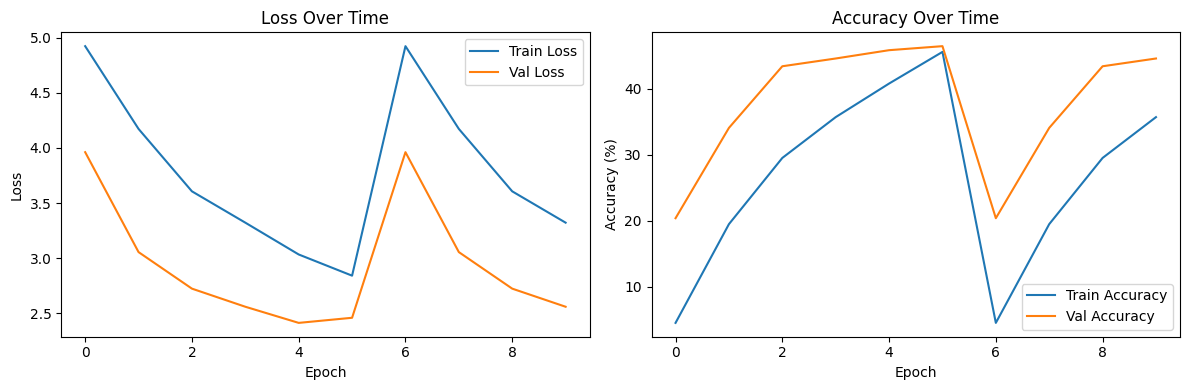

In [20]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()


In [23]:
# Load best model and evaluate on test set
print("\nEvaluating best model on test set...")
model.load_state_dict(torch.load("checkpoints/training_checkpoint_vgg19.pth")['model_state_dict'])
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Additional metrics
from sklearn.metrics import precision_recall_fscore_support

all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=range(num_classes))

print("\nPer-class metrics:")
for i, class_name in enumerate(full_dataset.classes):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.2f}")
    print(f"  Recall: {recall[i]:.2f}")
    print(f"  F1-score: {f1[i]:.2f}")

# Overall metrics
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print("\nOverall metrics:")
print(f"  Precision: {overall_precision:.2f}")
print(f"  Recall: {overall_recall:.2f}")
print(f"  F1-score: {overall_f1:.2f}")


Evaluating best model on test set...


/tmp/ipykernel_163976/4268728680.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/training_checkpoint_vgg19.pth")['model_sta


Test Loss: 2.4321, Test Accuracy: 46.75%


Testing:  27%|██▋       | 21/77 [00:41<01:51,  1.99s/it]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing:  78%|███████▊  | 60/77 [01:57<00:32,  1.94s/it]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Testing: 100%|██████████| 77/77 [02:30<00:00,  1.95s/it]


Per-class metrics:
Abra:
  Precision: 0.04
  Recall: 0.14
  F1-score: 0.06
Aerodactyl:
  Precision: 0.33
  Recall: 0.23
  F1-score: 0.27
Alakazam:
  Precision: 0.50
  Recall: 0.64
  F1-score: 0.56
Arbok:
  Precision: 1.00
  Recall: 0.57
  F1-score: 0.72
Arcanine:
  Precision: 0.42
  Recall: 0.69
  F1-score: 0.52
Articuno:
  Precision: 0.81
  Recall: 0.76
  F1-score: 0.79
Beedrill:
  Precision: 0.86
  Recall: 0.63
  F1-score: 0.73
Bellsprout:
  Precision: 0.95
  Recall: 0.95
  F1-score: 0.95
Blastoise:
  Precision: 0.67
  Recall: 0.40
  F1-score: 0.50
Bulbasaur:
  Precision: 1.00
  Recall: 0.64
  F1-score: 0.78
Butterfree:
  Precision: 1.00
  Recall: 0.75
  F1-score: 0.86
Caterpie:
  Precision: 0.85
  Recall: 0.50
  F1-score: 0.63
Chansey:
  Precision: 0.21
  Recall: 0.72
  F1-score: 0.32
Charizard:
  Precision: 0.46
  Recall: 0.46
  F1-score: 0.46
Charmander:
  Precision: 1.00
  Recall: 0.58
  F1-score: 0.74
Charmeleon:
  Precision: 1.00
  Recall: 0.33
  F1-score: 0.50
Clefable:
  Pre


/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
from PIL import Image

def predict_pokemon(model, image_path, ax=None):
    model.eval()
    true_label = Path(image_path).parent.name
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Handle plotting
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    ax.axis('off')
    
    # Make prediction
    image_tensor = val_test_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = output.max(1)
    
    prediction = full_dataset.classes[predicted.item()]
    is_correct = prediction == true_label
    color = 'green' if is_correct else 'red'
    
    ax.set_title(f'{true_label}\n→ {prediction}', 
                 color=color, 
                 fontsize=10)
    
    return prediction

def predict_random_samples(model, num_samples=9):
    # Get random indices
    indices = torch.randperm(len(test_dataset))[:num_samples]
    
    # Create subplot grid
    rows = int(np.ceil(np.sqrt(num_samples)))
    cols = int(np.ceil(num_samples / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*4))
    axes = axes.ravel()
    
    # Make predictions
    for idx, ax in zip(indices, axes):
        # Get image path from dataset
        image_path = test_dataset.dataset.samples[test_dataset.indices[idx]][0]
        predict_pokemon(model, image_path, ax)
        
    # Hide empty subplots if any
    for idx in range(num_samples, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()


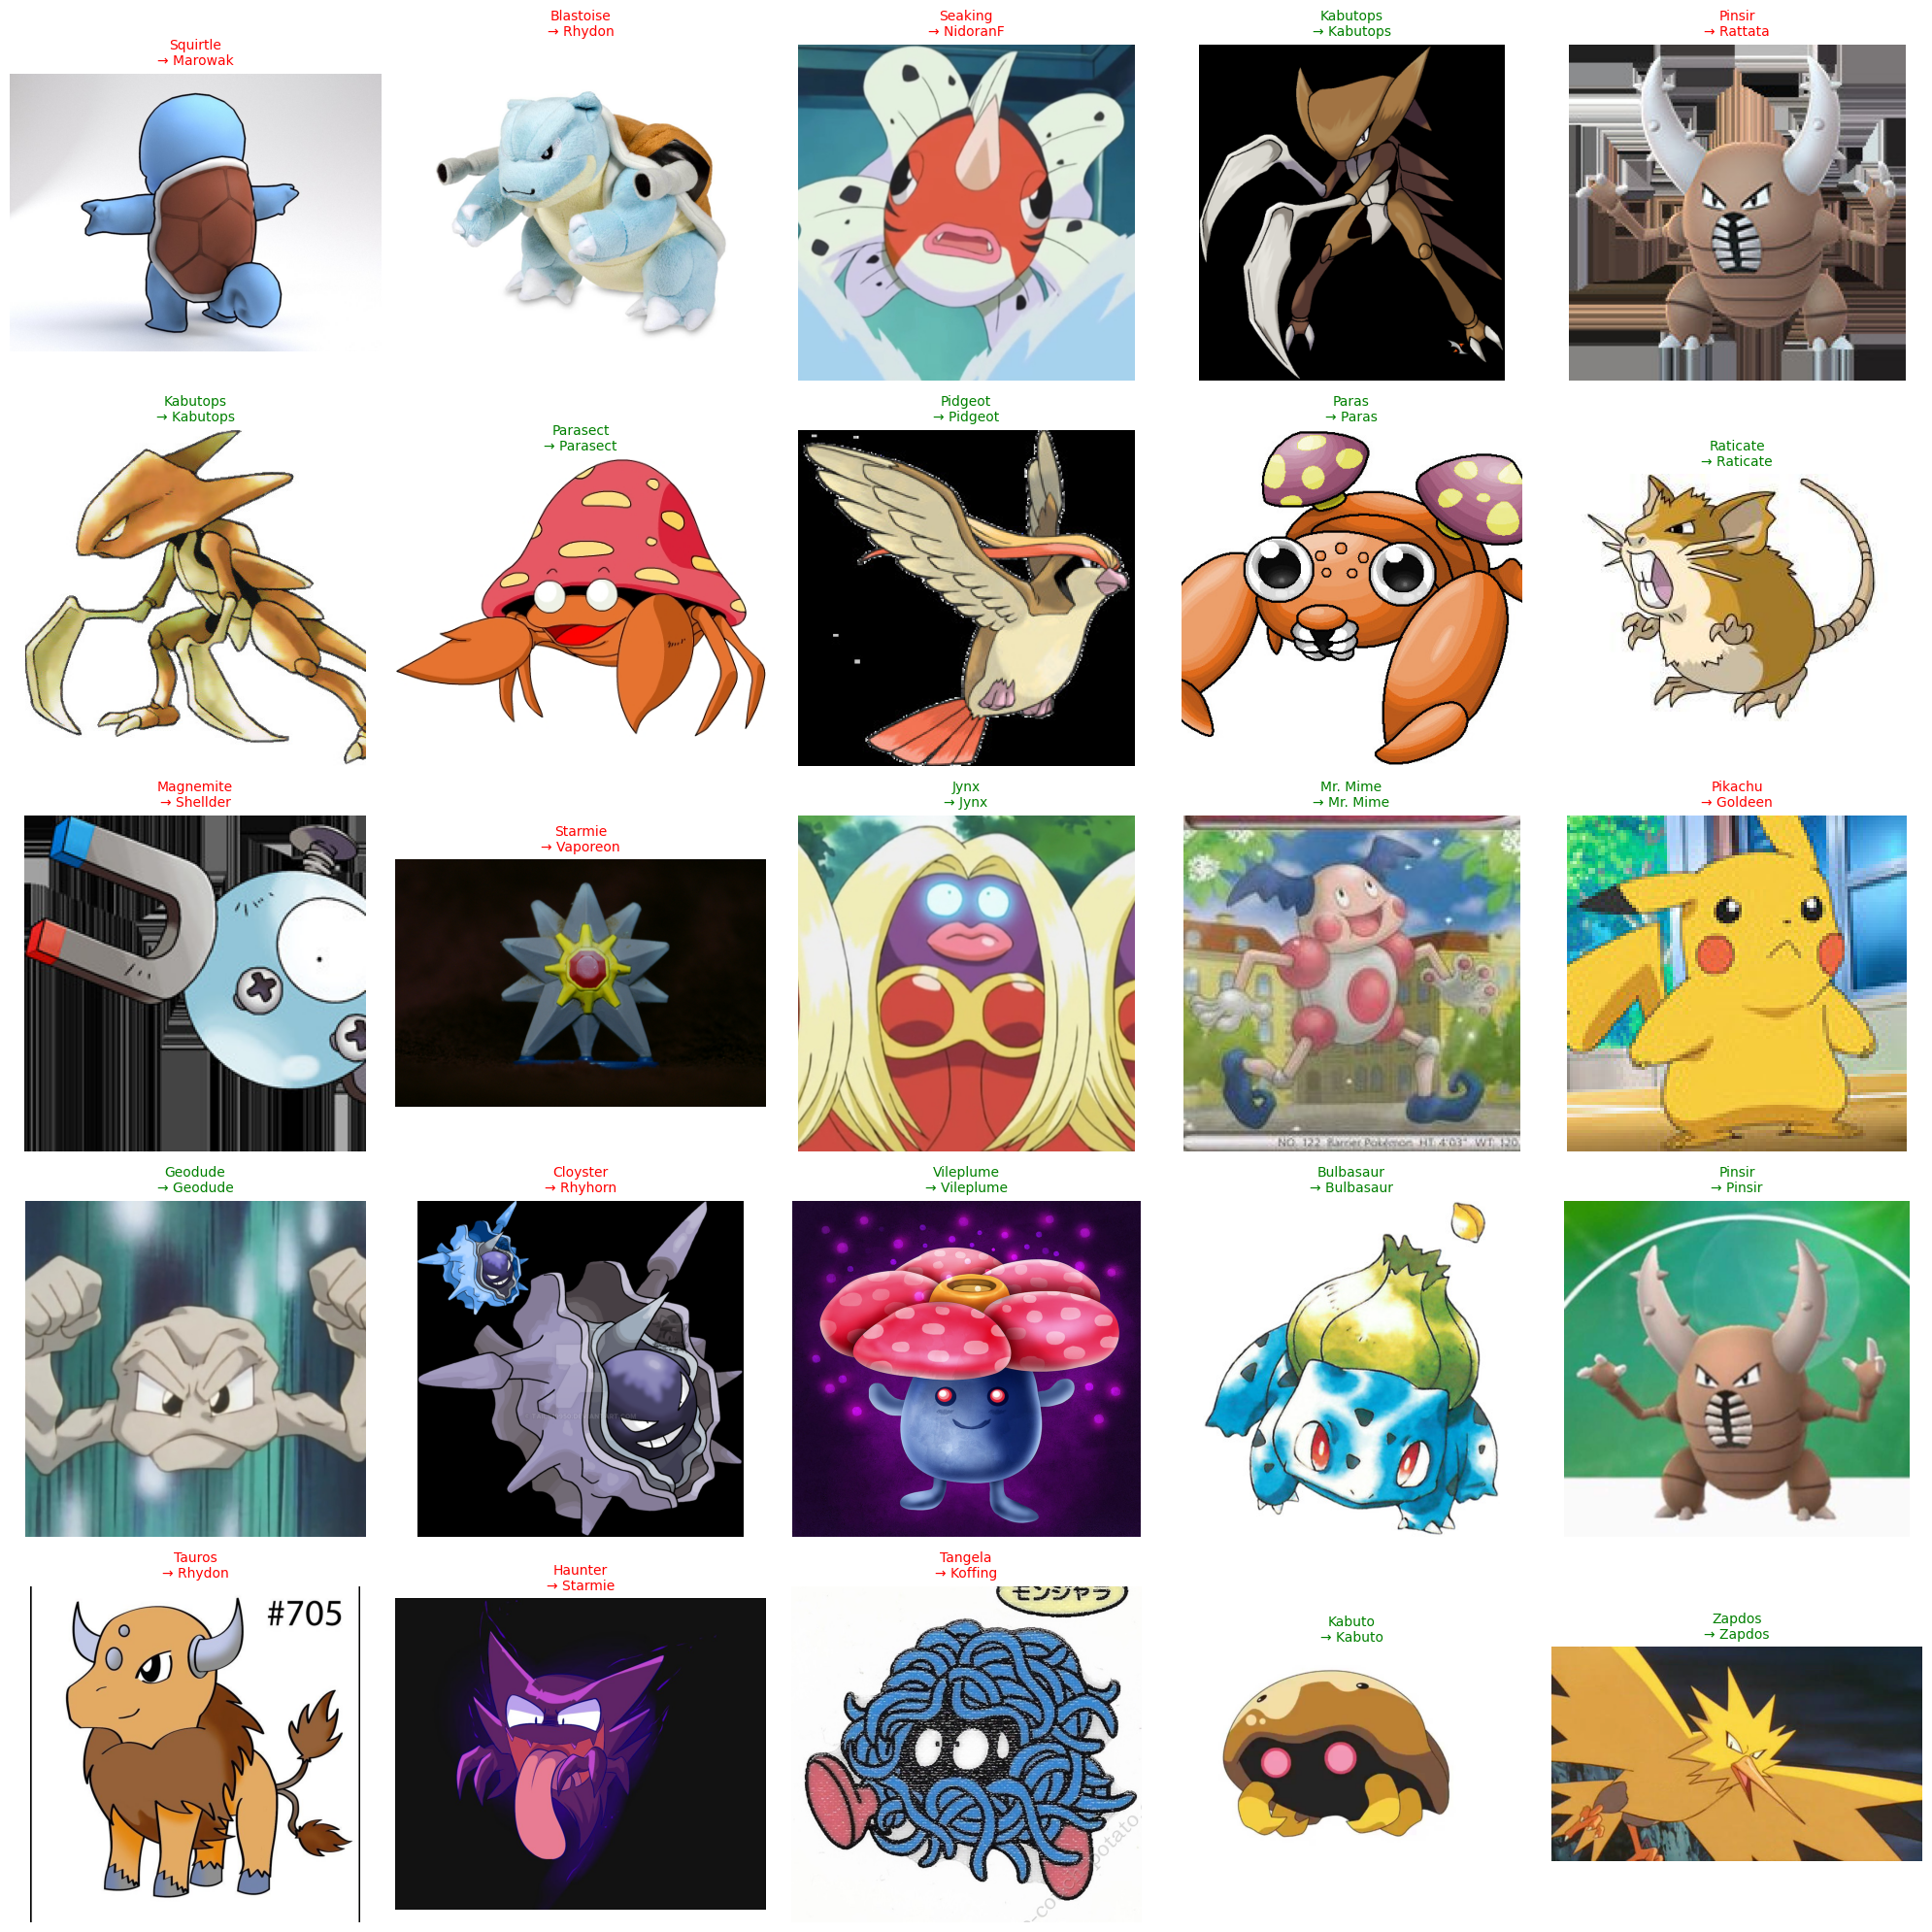

In [25]:
predict_random_samples(model, 25)
